In [171]:
#import Pkg
#Pkg.add("JuMP")
#Pkg.add("GLPK")
#Pkg.add("Gruobi")
#Pkg.add("DataFrames")
#Pkg.add("CSV")

In [172]:
using JuMP, GLPK
using DataFrames
using CSV

In [173]:
#load cost data
con_generation = CSV.File("../data/conventional_generators.csv") |> DataFrame

#load wind_technicaldata
wind_generation = CSV.File("../data/wind_farms.csv") |> DataFrame

# load wind profile
wind_profile = CSV.File("../data/wind_powerprofile_200.csv") |> DataFrame

# batteries
battery = CSV.File("../data/Battery.csv") |> DataFrame

# transmission_lines
transmission_lines = CSV.File("../data/transmission_lines.csv") |> DataFrame


Row,Battery,Location(Node),Production cost,Capacity[MWh],Power[MW]
,Int64,Int64,Int64,Int64,Int64
1,1,6,10,100,15
2,2,10,10,50,10
3,3,12,10,50,10
4,4,15,10,75,20
5,5,17,10,25,5


In [174]:
#demand bids
name = "demand_hour_0.csv"
demand_bids = CSV.File("../data/demand_bids_hour/" * name) |> DataFrame
 
# number of convential generators
G = size(con_generation, 1)

# number of demand
D = size(demand_bids, 1)

# number of wind generators
W = size(wind_generation, 1)

# number of batteries
B = size(battery, 1)

# number of transmission lines



5

In [175]:
# Initialize the DataFrame directly without dynamic column names
result_df = DataFrame(hour = Int[])
equilibrium_df = DataFrame(hour = Int[], market_price = Float64[])

# For x variables, manually add each column. This is a one-time setup.
for i in 1:G
    result_df[!, Symbol("x_con$i")] = Float64[]
end

# For w variables, manually add each column. This is a one-time setup.
for i in 1:W
    result_df[!, Symbol("x_wind$i")] = Float64[]
end

# For y variables, manually add each column. This is a one-time setup.
for i in 1:D
    result_df[!, Symbol("y$i")] = Float64[]
end

# For b variables, manually add each column. This is a one-time setup.
for i in 1:B
    result_df[!, Symbol("x_bat$i")] = Float64[]
end

In [176]:
println(result_df)

0×39 DataFrame
 Row │ hour   x_con1   x_con2   x_con3   x_con4   x_con5   x_con6   x_con7   x_con8   x_con9   x_con10  x_con11  x_con12  x_wind1  x_wind2  x_wind3  x_wind4  y1       y2       y3       y4       y5       y6       y7       y8       y9       y10      y11      y12      y13      y14      y15      y16      y17      x_bat1   x_bat2   x_bat3   x_bat4   x_bat5  
     │ Int64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64 
─────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [177]:
# Load demand bids data
demand_bids_all = [CSV.File("../data/demand_bids_hour/demand_hour_$(i-1).csv") |> DataFrame for i in 1:24]

# Create a new model with GLPK solver
model = Model(GLPK.Optimizer)

# Define the decision variables for every generator and hour
@variable(model, x_con[1:G, 1:24] >= 0)  # Power output variable for conventional generators
@variable(model, x_wind[1:W, 1:24] >= 0)  # Power output variable for wind generators
@variable(model, y[1:D, 1:24] >= 0)  # Demand variable
@variable(model, bat[1:B, 1:24])  # Battery variable


# Add constraints for each plant
for g in 1:G
    for hour in 1:24
        @constraint(model, x_con[g, hour] <= con_generation[g, 6])  # Set the upper bound
        @constraint(model, x_con[g, hour] >= 0)  # Set the lower bound
    end
end

# Add constraints for each wind farm
for w in 1:W
    for hour in 1:24
        @constraint(model, x_wind[w, hour] <= wind_profile[hour, w+1])  # Set the upper bound
        @constraint(model, x_wind[w, hour] >= 0)  # Set the lower bound
    end
end

# Add constraints for each demand bid
for d in 1:D
    for hour in 1:24
        @constraint(model, y[d, hour] <= demand_bids_all[hour][d, 2])  # Set the upper bound
        @constraint(model, y[d, hour] >= 0)  # Set the lower bound
    end
end

# Add temporary for each generator
for g in 1:G
    for hour in 2:24
        @constraint(model, x_con[g, hour] <= x_con[g, hour - 1] + con_generation[g, 7])  # Set the upper bound
        @constraint(model, x_con[g, hour] >= x_con[g, hour - 1] - con_generation[g, 8])  # Set the lower bound
    end
end

# add constraints for battery charging and discharging
for b in 1:B
    for hour in 1:24
        @constraint(model, bat[b, hour] <= battery[b, 5])  # Set the upper bound
        @constraint(model, bat[b, hour] >= -1 *battery[b, 5])  # Set the lower bound
    end
end

# add constraints for battery capacity
# sum all previous battery charging and discharging, they need to be below the battery capacity
for b in 1:B
    for hour in 2:24
        @constraint(model, sum(bat[b, h] for h in 1:hour) <= battery[b, 4])  # Set the upper bound
        @constraint(model, sum(bat[b, h] for h in 1:hour) >= 0)  # Set the lower bound
    end
end



# Define the objective function
@objective(model, Max, sum(demand_bids_all[hour][d, 3] * y[d, hour] for hour in 1:24, d in 1:D) -
                     sum(con_generation[g, 3] * x_con[g, hour] for hour in 1:24, g in 1:G) + sum(dual(balance[hour]) * bat[b, hour] for hour in 1:24, b in 1:B))

# Add the constraint for the balance between supply and demand for each hour
@constraint(model, balance[hour = 1:24], sum(x_con[g, hour] for g in 1:G) + sum(x_wind[w, hour] for w in 1:W) -
                                     sum(y[d, hour] for d in 1:D) + sum(bat[b, hour] for b in 1:B) == 0)

# Solve the model
optimize!(model)


# Check the status of the solution
status = termination_status(model)
if status == MOI.OPTIMAL
    println("Optimal solution found")
    #save the results in result and equilibrium dataframe
    for hour in 1:24
        push!(equilibrium_df, [hour, dual(balance[hour])])
    end


else
    println("No optimal solution found")
end


Optimal solution found

In [178]:
equilibrium_df

Row,hour,market_price
,Int64,Float64
1,1,11.63
2,2,10.52
3,3,10.52
4,4,10.52
5,5,10.52
6,6,7.0
7,7,14.04
8,8,17.915
9,9,17.915


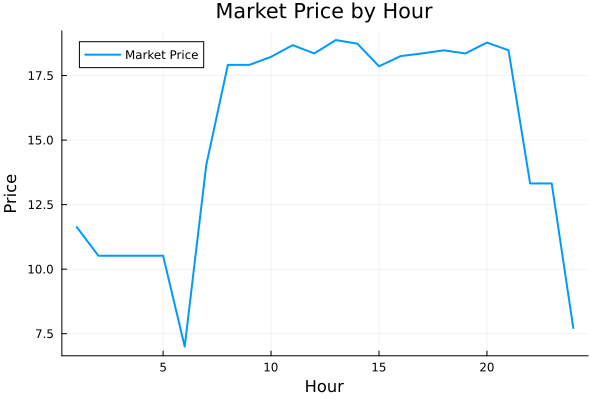

In [179]:
#plot equilibrium_df market_price in a line plot
using Plots
plot(equilibrium_df.hour, equilibrium_df.market_price, label="Market Price", xlabel="Hour", ylabel="Price", title="Market Price by Hour", lw=2)

In [180]:
#plot equilibrium_df market_quantity in a bar chart
bar(equilibrium_df.hour, equilibrium_df.market_quantity, label="Market Quantity", xlabel="Hour", ylabel="Quantity", title="Market Quantity by Hour")

ArgumentError: ArgumentError: column name :market_quantity not found in the data frame

In [181]:
#save result_df to csv
CSV.write("results/market_clearing_model2.csv", result_df)

"results/market_clearing_model2.csv"